In [104]:
import os
# change to the root directory of the project
while os.getcwd().split('/')[-1] != 'spectral-properties-of-NN':
    os.chdir('..')
print(os.getcwd())

/home/nadezhda/Desktop/SEMESTER PROJECT/spectral-properties-of-NN


In [105]:
# arguments
import yaml
from omegaconf import OmegaConf
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
# custom
from src.utils.general_utils import lp_distance

<div class="alert alert-block alert-success">
  ❓ <strong> Question: </strong> 

   What is a sufficiently large batch size that gives a trustworthy estimation of the spectrum computed by the Lanczos algorithm?

</div>

### Experiment configuration

In [106]:
EXPERIMENT = "01"
MODEL = "untrained"
LANCZOS = "slow"
# get the results directory path
results_dir = f"experiments/{EXPERIMENT}/results/{MODEL}/{LANCZOS}"
print(f"Results directory: {results_dir}")
# load "groundtruth" eigenvalues
full_eigenvalues = torch.load(os.path.join(results_dir, "HBS_60000/01_run/eigenvalues_iter_100.pt"))

Results directory: experiments/01/results/untrained/slow


In [107]:
# get model information from config file
args = OmegaConf.create(yaml.load(open(f"experiments/{EXPERIMENT}/config.yaml"), Loader=yaml.SafeLoader))
plot_title = f"{MODEL.capitalize()} - {args.model_name} - {args.dataset} - Layers: {args.layer_sizes}"
print(f"Plot title: {plot_title}")

Plot title: Untrained - NeuralNetwork - MNIST - Layers: [784, 16, 10]


### Extract configurations and eigenvalues

In [108]:
# create lists to store configurations and data
configs = []
all_eigenvalues = []

for batch_dir in sorted(os.listdir(results_dir), key=lambda x: int(x.split('_')[1])):
    if batch_dir.startswith('HBS_'):
        batch_size = int(batch_dir.split('_')[1])
        batch_path = os.path.join(results_dir, batch_dir)                
        for run_dir in sorted(os.listdir(batch_path)):
            if run_dir.endswith('_run'):
                run_path = os.path.join(batch_path, run_dir)
                run_num = int(run_dir.split('_')[0])
                # skip runs other than 1, 2, 3
                if run_num not in [1, 2, 3]:
                    continue
                for file in sorted(os.listdir(run_path)):
                    if file.startswith('eigenvalues_iter_100'):
                        iter_num = int(file.split('_')[-1].split('.')[0])
                        # skip iterations other than 100
                        if iter_num != 100:
                            continue
                        # load data
                        runtime = torch.load(os.path.join(run_path, f'runtime_{iter_num}.npy'))
                        gradient_norm = torch.load(os.path.join(run_path, f'gradient_norm_{iter_num}.npy'))
                        eigenvalues = torch.load(os.path.join(run_path, f'eigenvalues_iter_{iter_num}.pt'))
                        weights = torch.load(os.path.join(run_path, f'weights_iter_{iter_num}.pt'))
                        # store configuration and data
                        configs.append({
                            'lanczos': LANCZOS,
                            'batch_size': batch_size,
                            'run_num': run_num,
                            'iter_num': iter_num,
                            'runtime': runtime,
                            'gradient_norm': gradient_norm,
                            'L1 distance': lp_distance(torch.FloatTensor(eigenvalues), torch.FloatTensor(full_eigenvalues), 1).item(),
                            'L2 distance': lp_distance(torch.FloatTensor(eigenvalues), torch.FloatTensor(full_eigenvalues), 2).item()
                        })
                        all_eigenvalues.append(eigenvalues)

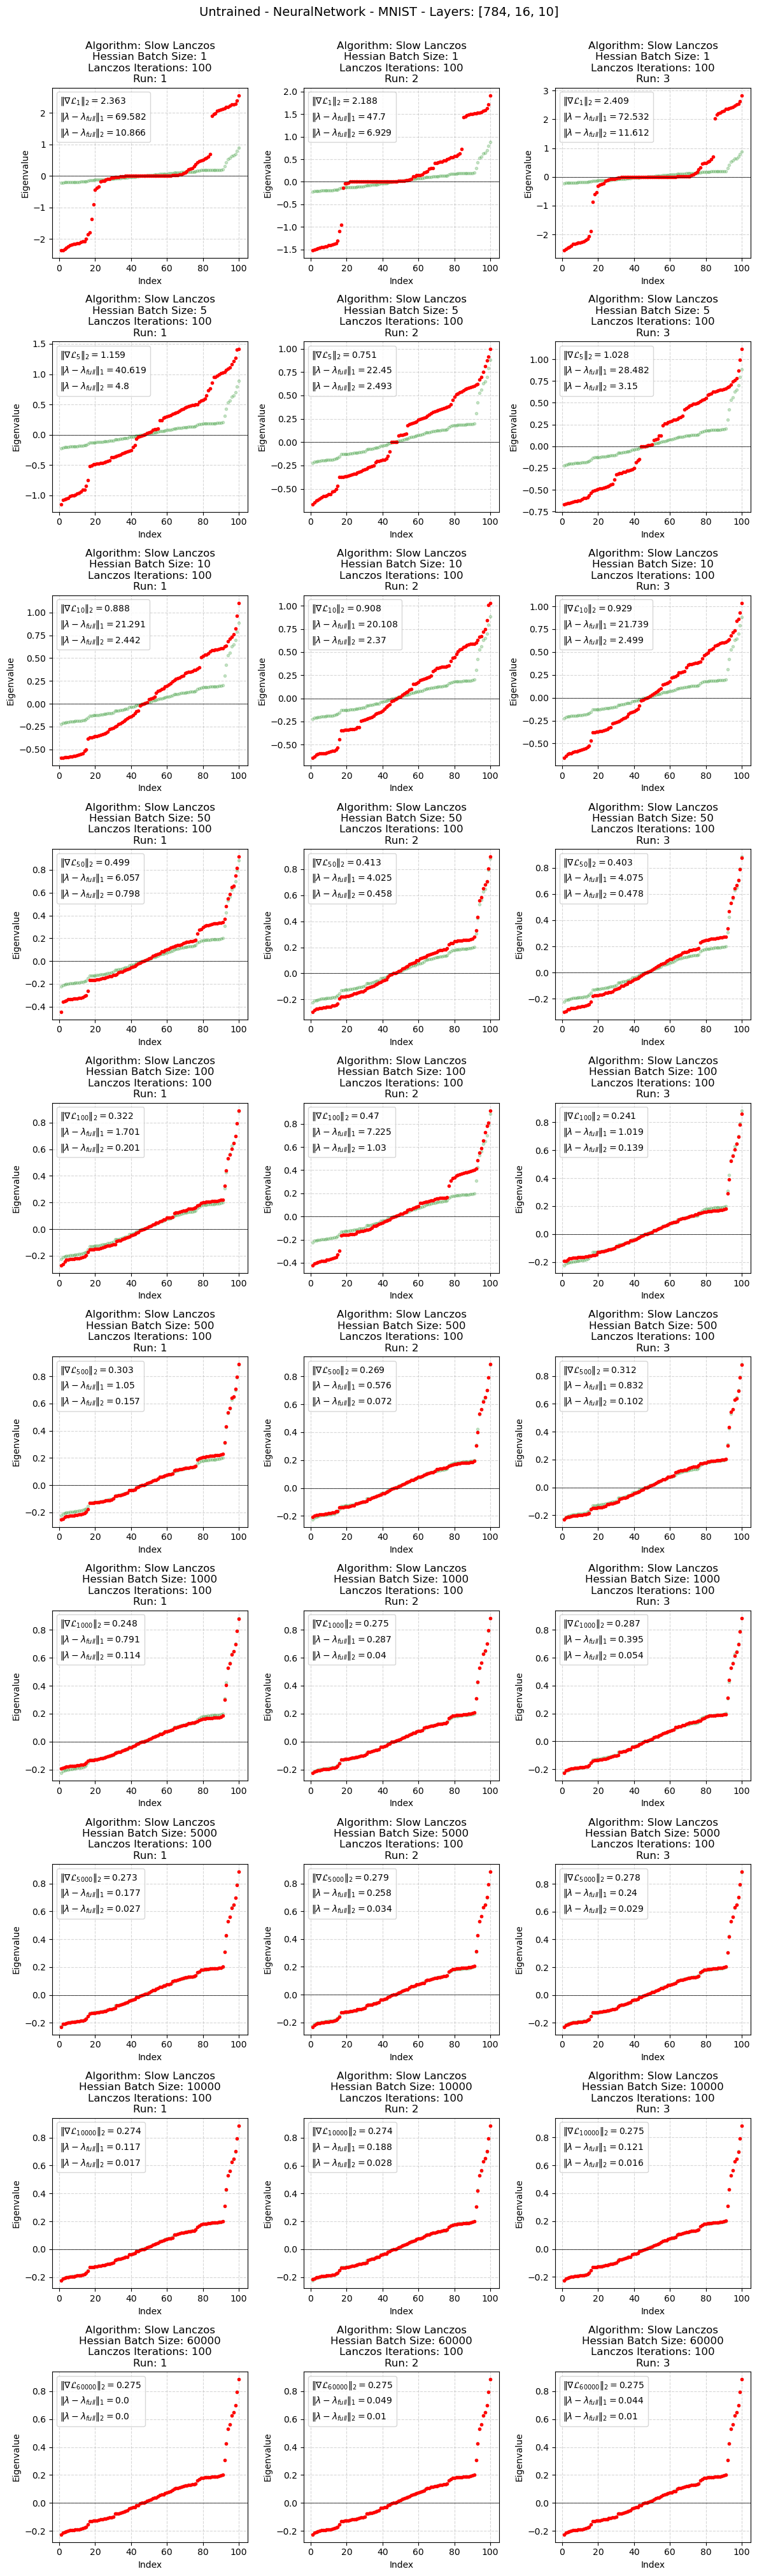

In [109]:
# create subplot grid
n_plots = len(configs)
n_cols = 3  
n_rows = (n_plots + n_cols - 1) // n_cols
# create figure
plt.figure(figsize=(4*n_cols, 4*n_rows))
# create subplots
for idx, (config, eigenvalues) in enumerate(zip(configs, all_eigenvalues)):
    plt.subplot(n_rows, n_cols, idx + 1)
    sorted_eigenvalues = np.sort(eigenvalues)
    x_indices = np.arange(1, len(sorted_eigenvalues) + 1)
    plt.plot(x_indices, np.sort(full_eigenvalues), marker="o", linestyle="", color="green", markersize=3, alpha=0.2)
    plt.plot(x_indices, sorted_eigenvalues, marker="o", linestyle="", color="red", markersize=3)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)  # add horizontal line at y=0
    plt.title(f"Algorithm: {config['lanczos'].capitalize()} Lanczos\nHessian Batch Size: {config['batch_size']}\nLanczos Iterations: {config['iter_num']}\nRun: {config['run_num']}")
    legend = [
        Patch(facecolor='white', edgecolor='white', label=fr"$\| \nabla \mathcal{{L}}_{{ {config['batch_size'] }}} \|_2 = {np.round(config['gradient_norm'], 3)}$"), 
        Patch(facecolor='white', edgecolor='white', label=fr"$\| \lambda - \lambda_{{full}} \|_1 = {np.round(config['L1 distance'], 3)}$"), 
        Patch(facecolor='white', edgecolor='white', label=fr"$\| \lambda - \lambda_{{full}} \|_2 = {np.round(config['L2 distance'], 3)}$")
        ]
    plt.legend(handles=legend, loc='upper left', handlelength=0, handletextpad=0)
    plt.grid(True, alpha=0.5, linestyle="--")
    plt.xlabel('Index')
    plt.ylabel('Eigenvalue')
plt.tight_layout()
plt.suptitle(plot_title, y=1.01, fontsize=14)
plt.savefig(f"results/plots/batch size effect/{plot_title}.png")
plt.show()

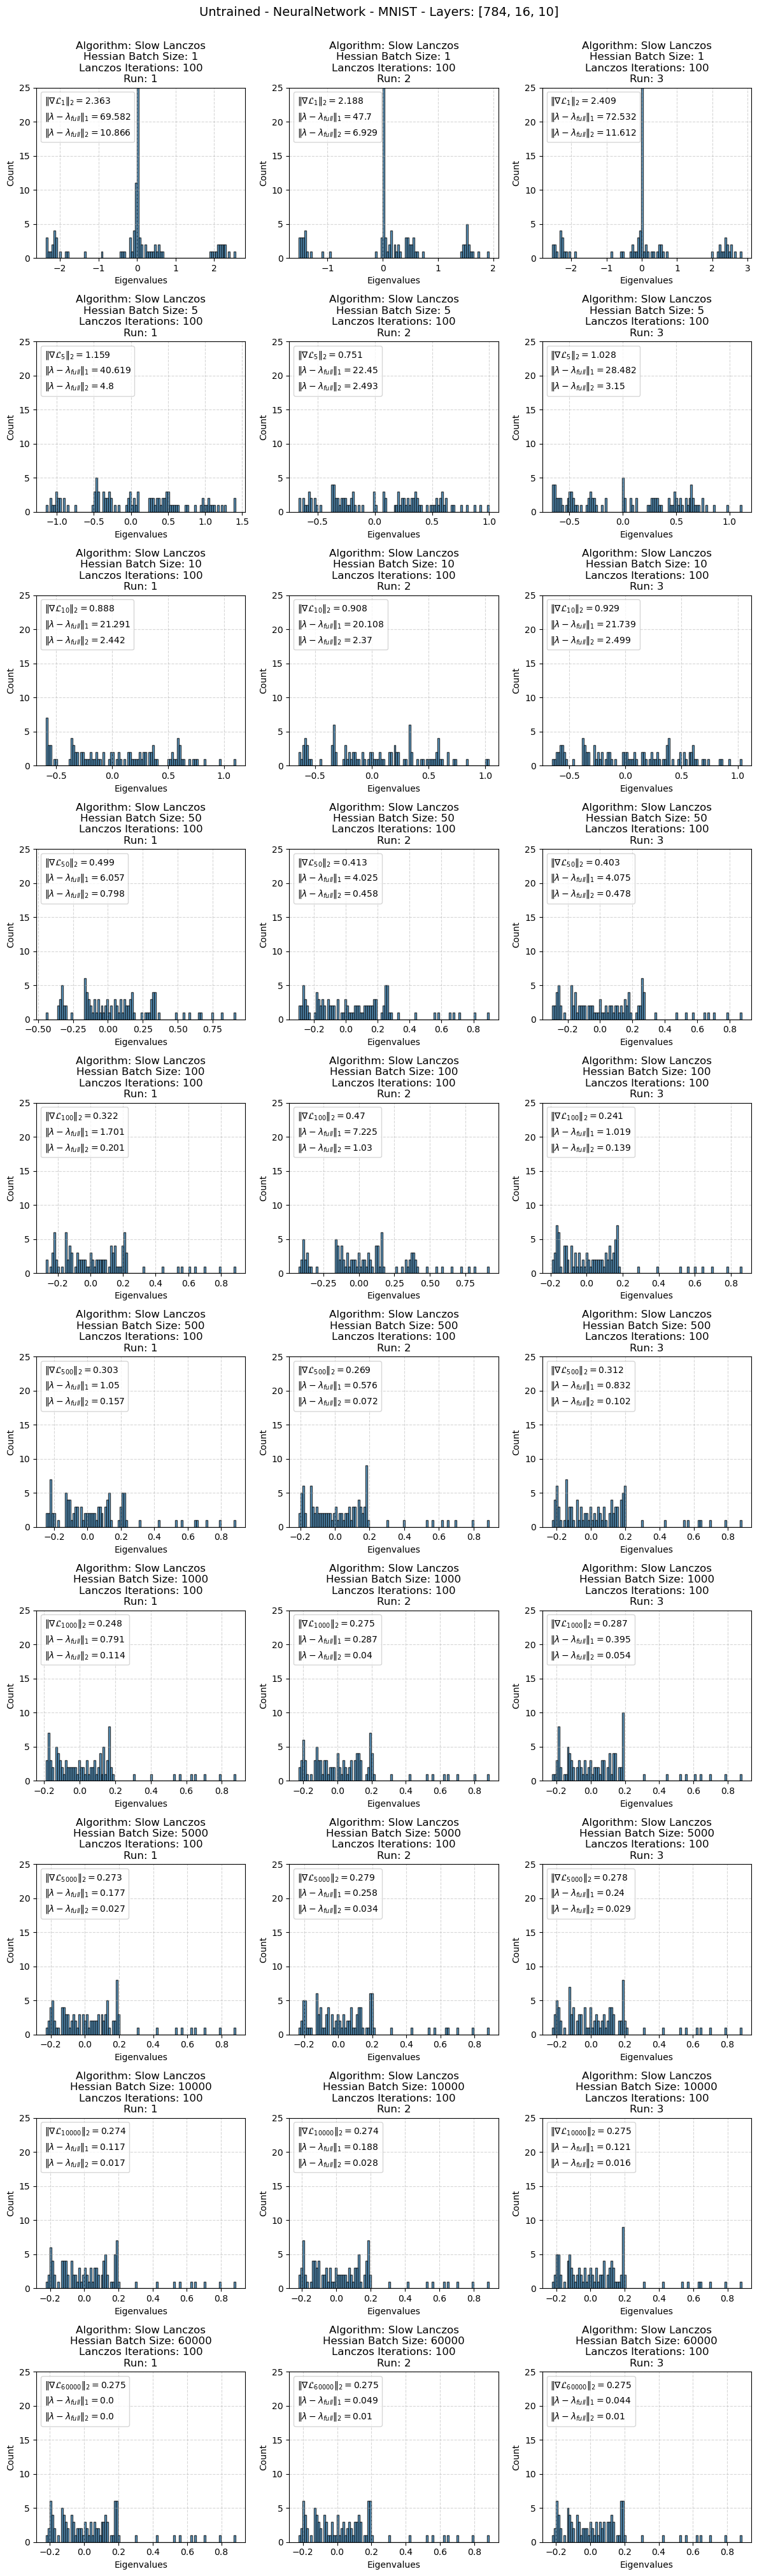

In [110]:
# create subplot grid
n_plots = len(configs)
n_cols = 3  
n_rows = (n_plots + n_cols - 1) // n_cols
# create figure
plt.figure(figsize=(4*n_cols, 4*n_rows))
# create subplots
for idx, (config, eigenvalues) in enumerate(zip(configs, all_eigenvalues)):
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.hist(eigenvalues, bins=100, alpha=0.7, edgecolor='black')
    plt.title(f"Algorithm: {config['lanczos'].capitalize()} Lanczos\nHessian Batch Size: {config['batch_size']}\nLanczos Iterations: {config['iter_num']}\nRun: {config['run_num']}")
    legend = [
        Patch(facecolor='white', edgecolor='white', label=fr"$\| \nabla \mathcal{{L}}_{{ {config['batch_size'] }}} \|_2 = {np.round(config['gradient_norm'], 3)}$"), 
        Patch(facecolor='white', edgecolor='white', label=fr"$\| \lambda - \lambda_{{full}} \|_1 = {np.round(config['L1 distance'], 3)}$"), 
        Patch(facecolor='white', edgecolor='white', label=fr"$\| \lambda - \lambda_{{full}} \|_2 = {np.round(config['L2 distance'], 3)}$")
        ]
    plt.legend(handles=legend, loc='upper left', handlelength=0, handletextpad=0)
    plt.grid(True, alpha=0.5, linestyle="--")
    plt.xlabel("Eigenvalues")
    plt.ylabel("Count")
    plt.ylim(0, 25)

plt.tight_layout()
plt.suptitle(plot_title, y=1.01, fontsize=14)
plt.show()

### Plots: L1 distance, L2 distance and Runtime vs Batch size

In [111]:
# create dictionaries to store data
l1_distances = {}
l2_distances = {}
runtimes = {}

for batch_dir in sorted(os.listdir(results_dir), key=lambda x: int(x.split('_')[1])):
    if batch_dir.startswith('HBS_'):
        batch_size = int(batch_dir.split('_')[1])
        if batch_size not in l1_distances:
            l1_distances[batch_size] = []
            l2_distances[batch_size] = []
            runtimes[batch_size] = []
        batch_path = os.path.join(results_dir, batch_dir)                
        for run_dir in sorted(os.listdir(batch_path)):
            if run_dir.endswith('_run'):
                run_path = os.path.join(batch_path, run_dir)
                run_num = int(run_dir.split('_')[0])
                for file in sorted(os.listdir(run_path)):
                    if file.startswith('eigenvalues_iter_100'):
                        iter_num = int(file.split('_')[-1].split('.')[0])
                        # skip iterations other than 100
                        if iter_num != 100:
                            continue
                        # load data
                        runtime = torch.load(os.path.join(run_path, f'runtime_{iter_num}.npy'))
                        gradient_norm = torch.load(os.path.join(run_path, f'gradient_norm_{iter_num}.npy'))
                        eigenvalues = torch.load(os.path.join(run_path, f'eigenvalues_iter_{iter_num}.pt'))
                        # add data to dictionaries
                        l1_distances[batch_size].append(lp_distance(torch.FloatTensor(eigenvalues), torch.FloatTensor(full_eigenvalues), 1).item())
                        l2_distances[batch_size].append(lp_distance(torch.FloatTensor(eigenvalues), torch.FloatTensor(full_eigenvalues), 2).item())
                        runtimes[batch_size].append(runtime)

# convert lists to numpy arrays
l1_distances  = {k: np.array(v) for k, v in l1_distances.items()}
l2_distances = {k: np.array(v) for k, v in l2_distances.items()}
runtimes = {k: np.array(v) for k, v in runtimes.items()}

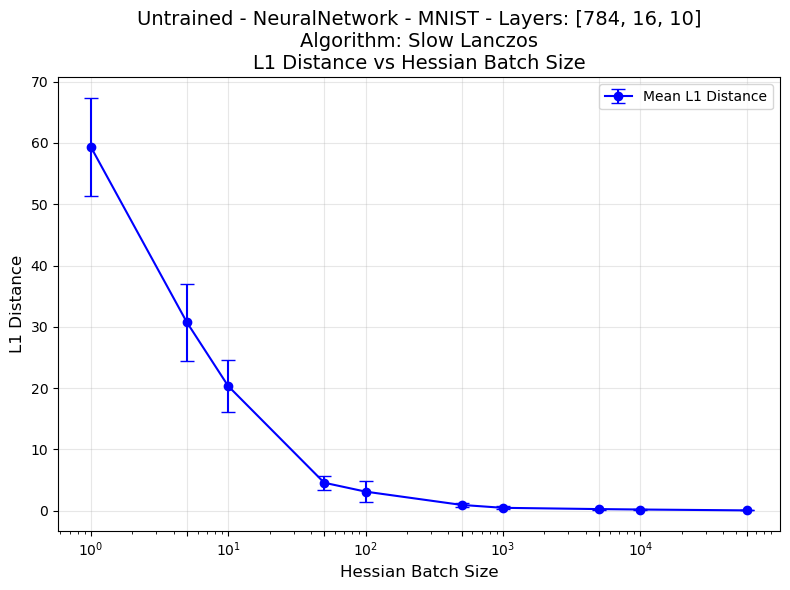

In [112]:
# prepare data for plotting
batch_sizes = []
means = []
std_devs = []

for batch_size, distances in l1_distances.items():
    batch_sizes.append(batch_size)
    means.append(np.mean(distances))
    std_devs.append(np.std(distances))

# create the error plot
plt.figure(figsize=(8, 6))
plt.errorbar(batch_sizes, means, yerr=std_devs, fmt='o-', capsize=5, color="blue", label='Mean L1 Distance')
plt.xscale('log')
plt.xlabel('Hessian Batch Size', fontsize=12)
plt.ylabel('L1 Distance', fontsize=12)
plt.title(f'{plot_title}\nAlgorithm: {LANCZOS.capitalize()} Lanczos\nL1 Distance vs Hessian Batch Size', fontsize=14)
plt.xticks(batch_sizes)  # Ensure x-ticks are at the batch sizes
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

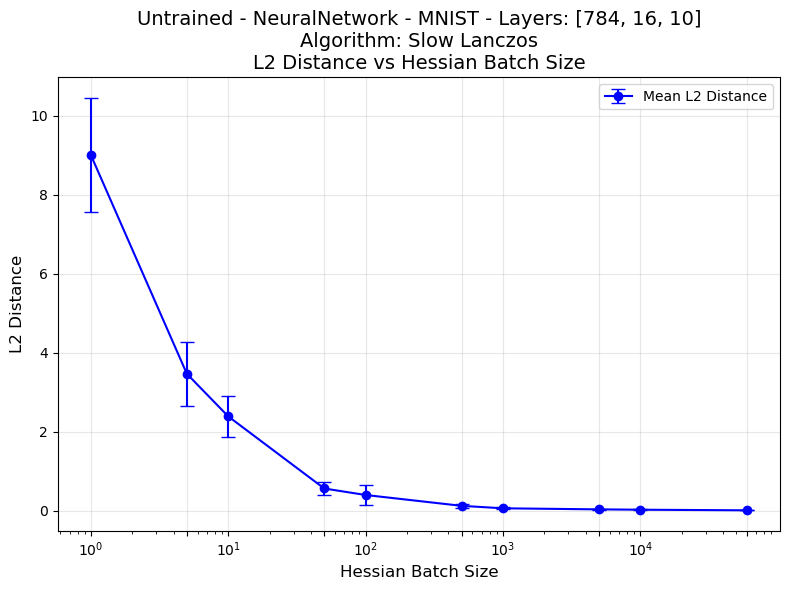

In [113]:
# prepare data for plotting
batch_sizes = []
means = []
std_devs = []

for batch_size, distances in l2_distances.items():
    batch_sizes.append(batch_size)
    means.append(np.mean(distances))
    std_devs.append(np.std(distances))

# create the error plot
plt.figure(figsize=(8, 6))
plt.errorbar(batch_sizes, means, yerr=std_devs, fmt='o-', capsize=5, color="blue", label='Mean L2 Distance')
plt.xscale('log')
plt.xlabel('Hessian Batch Size', fontsize=12)
plt.ylabel('L2 Distance', fontsize=12)
plt.title(f'{plot_title}\nAlgorithm: {LANCZOS.capitalize()} Lanczos\nL2 Distance vs Hessian Batch Size', fontsize=14)
plt.xticks(batch_sizes)  # Ensure x-ticks are at the batch sizes
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

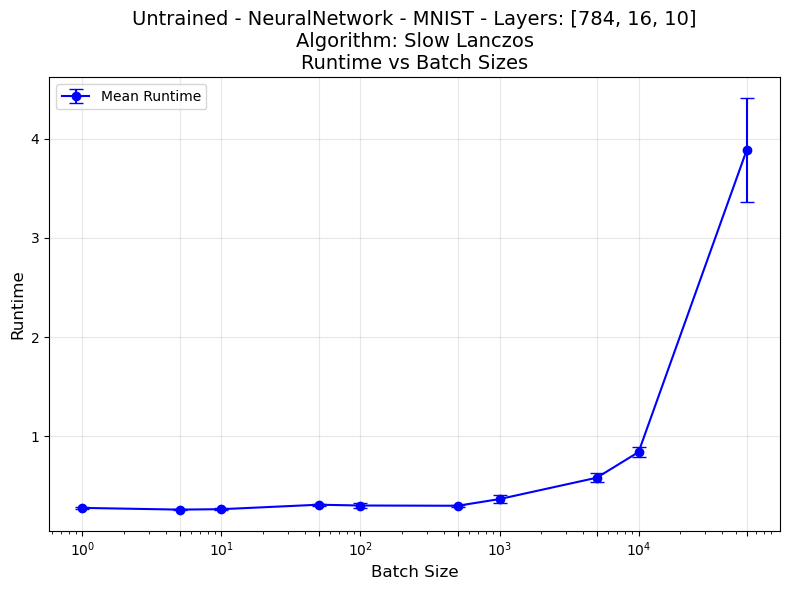

In [114]:
# prepare data for plotting
batch_sizes = []
means = []
std_devs = []

for batch_size, distances in runtimes.items():
    batch_sizes.append(batch_size)
    means.append(np.mean(distances))
    std_devs.append(np.std(distances))

# create the error plot
plt.figure(figsize=(8, 6))
plt.errorbar(batch_sizes, means, yerr=std_devs, fmt='o-', capsize=5, color="blue", label='Mean Runtime')
plt.xscale('log')
plt.xlabel('Batch Size', fontsize=12)
plt.ylabel('Runtime', fontsize=12)
plt.title(f'{plot_title}\nAlgorithm: {LANCZOS.capitalize()} Lanczos\nRuntime vs Batch Sizes', fontsize=14)
plt.xticks(batch_sizes)  # Ensure x-ticks are at the batch sizes
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()